# Single proliferation event within larger spheroid

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi
import scipy.interpolate as sci

import os 
import json

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl
import cbmos.utils as ut

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

from matplotlib import cm
import matplotlib.colors as mcolors

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance

dim = 3
seed = 67

t_data = [0,tf]

#force_names = ['cubic', 'pw. quad.', 'GLS']
force = 'cubic'
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}


In [3]:
#algorithms
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap' ]

models = {'EF_glob_adap_acc': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
          'EF_glob_adap_stab': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),  
          'EF_local_adap': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim), 
          'EB_global_adap': cbmos.CBModel(ff.Cubic(), eb.solve_ivp, dim) }

eta = 1e-4

params = {'EF_glob_adap_acc': {'eta': eta},
          'EF_glob_adap_stab': {'eta': eta, 'jacobian': models['EF_glob_adap_stab'].jacobian, 'force_args': params_cubic, 'always_calculate_Jacobian': True}, 
          'EF_local_adap': {'eta': eta, 'jacobian': models['EF_glob_adap_stab'].jacobian, 'force_args': params_cubic, 'always_calculate_Jacobian': True, 'local_adaptivity': True, 'm0': 4}, 
          'EB_global_adap': {'eta': eta}
         }


labels = {'EF_glob_adap_acc': 'Alg. I (GAFE)', 
          'EF_glob_adap_stab': 'Alg. II (GAFES)' ,  
          'EF_local_adap': 'Alg. III (LAFE)', 
          'EB_global_adap': 'Alg. IV (GABE)'
         }

In [4]:
cell_list = ut.setup_locally_compressed_spheroid(6,6,6, seed=seed)

## Time step sizes as a function of chosen absolute error

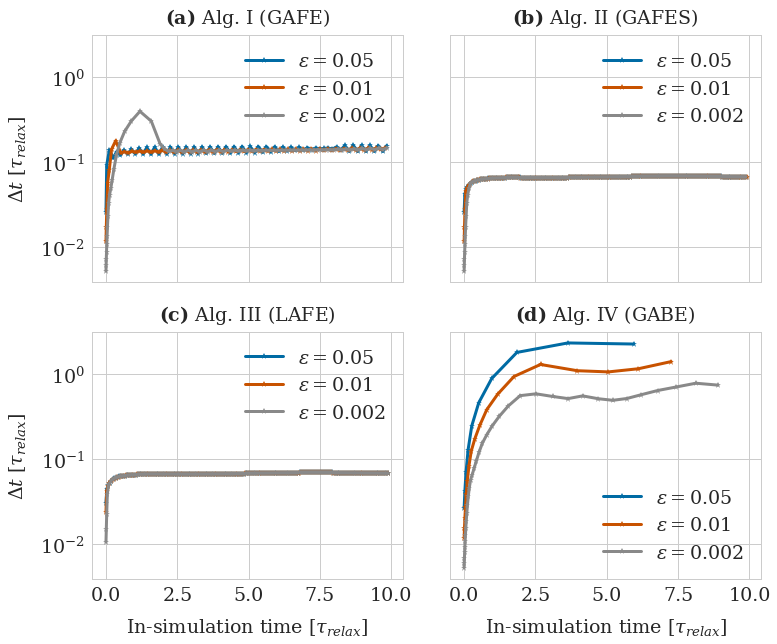

In [5]:
colors = [defcolors[0], defcolors[5], defcolors[6]]

# Combine into single figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True, gridspec_kw={'hspace':0.2, 'wspace': 0.15})
      
axes = {'EF_glob_adap_acc': ax1, 'EF_glob_adap_stab': ax2 ,  'EF_local_adap': ax3, 'EB_global_adap': ax4}

epsilons = [0.05, 0.01, 0.002]

      
for alg in algorithms:
        
    for i, eps in enumerate(epsilons):
        
        params[alg]['eps'] = eps
        ts, history = models[alg].simulate(cell_list, t_data, params_cubic, params[alg], seed=seed)

        axes[alg].semilogy(ts[:-2], np.diff(ts)[:-1],'-*', label='$\epsilon=$'+str(eps), color=colors[i]) # last dt smaller to reach end time exactly - do not plot
        
    axes[alg].legend()
   

ax1.set_title(r'$\bf{(a)}$ Alg. I (GAFE)')
ax2.set_title(r'$\bf{(b)}$ Alg. II (GAFES)')
ax3.set_title(r'$\bf{(c)}$ Alg. III (LAFE)')
ax4.set_title(r'$\bf{(d)}$ Alg. IV (GABE)')
    
ax1.set(ylabel=r'$\Delta t \ [\tau_{relax}]$')
ax3.set(ylabel=r'$\Delta t \ [\tau_{relax}]$')    
ax3.set(xlabel=r'In-simulation time [$\tau_{relax}$]')
ax4.set(xlabel=r'In-simulation time [$\tau_{relax}$]')

#ax1.set_xscale('function', functions=(forward, inverse))
#ax1.set_xlim([-0.5, 10.5])

plt.savefig('prolif_within_spheroid.pdf', bbox_inches='tight')

Note that the exact amount of overshoot for the globally adaptive EF scheme varies slightly between runs, if the division direction chosen within the setup of the cell configuration is not fixed. (It also varies depending on eta, however, there is no clear trend if larger eta or smaller eta are better.)

## Convergence analysis

In [6]:
# calculate reference solution
dt_ref = 0.0005
tf = 3.0
#N_ref = int(1/dt_ref*tf)+1

cbmodel = cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim)

ts_ref, history = cbmodel.simulate(cell_list, [0, tf], params_cubic, {'dt': dt_ref}, seed=seed)

ref_traj = np.array([[cell.position for cell in cell_list] for cell_list in history]) # (N_ref, n_cells, dim)

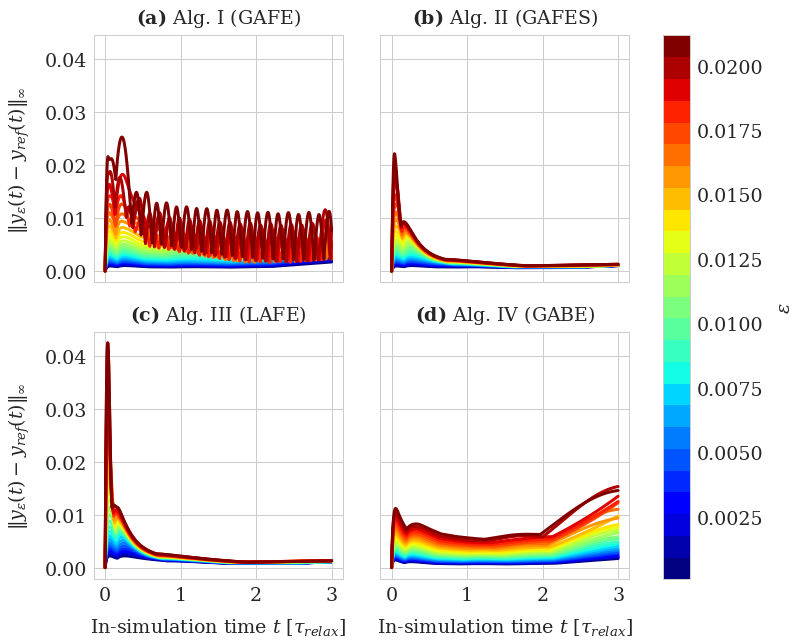

In [7]:
# Combine into single figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True, gridspec_kw={'hspace':0.2, 'wspace': 0.15})
      
axes = {'EF_glob_adap_acc': ax1, 'EF_glob_adap_stab': ax2 ,  'EF_local_adap': ax3, 'EB_global_adap': ax4}

r = 25
eps_values = np.array([0.0001*1.25**n for n in range(0, r)])
map_eps_values_to_unit_interval = [ np.log(10000*(x-np.min(range(0, r))))/(np.max(range(0, r))-np.min(range(0, r)))/np.log(1.25) for x in eps_values]
colors = [ cm.jet(x) for x in map_eps_values_to_unit_interval ]

sol = {}
for alg in algorithms:
    
    for i, eps in enumerate(eps_values):
        
        params[alg]['eps'] = eps
        ts, history = models[alg].simulate(cell_list, [0, tf], params_cubic, params[alg], seed=seed)
        
        traj = np.array([[cell.position for cell in cell_list] for cell_list in history]) # (N, n_cells, dim)
        
        interp = sci.interp1d(ts, traj, axis=0, bounds_error=False, 
                              kind='cubic', fill_value=tuple(traj[[0, -1], :, :]))(ts_ref[:])
        
        error = np.linalg.norm(np.linalg.norm(interp - ref_traj, ord=np.inf, axis=1)/np.linalg.norm(ref_traj, ord=np.inf, axis=1))
        sol.setdefault(alg, []).append(error)
                
        axes[alg].plot(ts_ref, np.linalg.norm(np.reshape(interp - ref_traj, (-1, dim*len(history[0]))), ord=np.inf, axis=1), color=colors[i])

        
#    axes[alg].legend()

ax1.set_title(r'$\bf{(a)}$ Alg. I (GAFE)')
ax2.set_title(r'$\bf{(b)}$ Alg. II (GAFES)')
ax3.set_title(r'$\bf{(c)}$ Alg. III (LAFE)')
ax4.set_title(r'$\bf{(d)}$ Alg. IV (GABE)')
    
ax1.set(ylabel=r'$\Vert y_{\epsilon}(t)-y_{ref}(t)\Vert_{\infty}$')
ax3.set(ylabel=r'$\Vert y_{\epsilon}(t)-y_{ref}(t)\Vert_{\infty}$')  
ax3.set(xlabel=r'In-simulation time $t$ [$\tau_{relax}$]')
ax4.set(xlabel=r'In-simulation time $t$ [$\tau_{relax}$]')

cma = mcolors.ListedColormap(colors, name='from_list', N=None) # creation of a user cmap
msm = cm.ScalarMappable(cmap=cma) 
msm.set_array(eps_values) 
cbar = fig.colorbar(msm, ax=[ax1, ax2, ax3, ax4])
cbar.set_label('$\epsilon$', rotation=90)

plt.savefig('spheroid_errors.pdf', bbox_inches='tight')

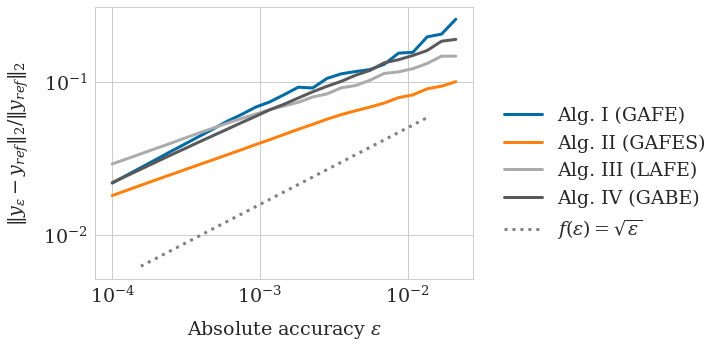

In [10]:
fig, ax = plt.subplots(1, figsize=(10, 5))
for alg in algorithms:
    ax.loglog(eps_values, sol[alg], '-', label=labels[alg])

ax.loglog(eps_values[2:-2], eps_values[2:-2]**0.5*0.5, ':',
           label='$f(\epsilon)= \sqrt{\epsilon}$', color='grey')
ax.set(xlabel='Absolute accuracy $\epsilon$')
ax.set(ylabel=r'$\Vert y_{\epsilon}-y_{ref}\Vert_{2}/\Vert y_{ref}\Vert_{2}$')
fig.legend(loc=7)
fig.subplots_adjust(right=0.65)  
#plt.grid(True)
plt.savefig('spheroid_order.pdf', bbox_inches='tight')

## Studying LAFE

We now consider the max two level version with m


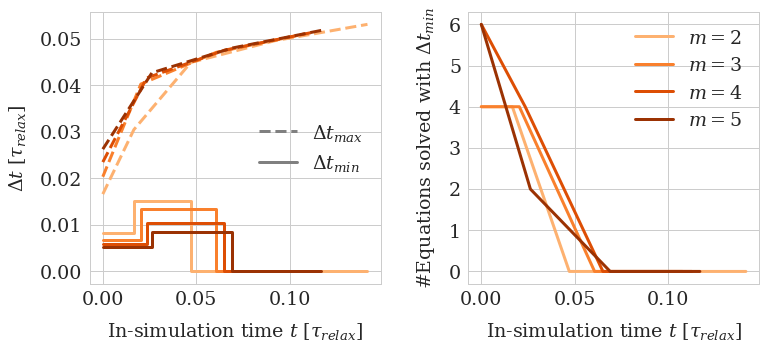

In [42]:
alg = 'EF_local_adap'
params[alg]['write_to_file'] = True
params[alg]['eps'] = 0.01

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5),  gridspec_kw={'hspace':0.2, 'wspace': 0.3})

cmap = cm.get_cmap('Oranges', 12)

for i, m in enumerate([2, 3, 4, 5]):
    params[alg]['m0'] = m

    try:
        os.remove('n_eq_per_level.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('step_sizes_dt_0.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('step_sizes_dt_1.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
        
    ts, history = models[alg].simulate(cell_list, [0, 0.15], params_cubic, params[alg], seed=seed)

    dt_0s = np.loadtxt('step_sizes_dt_0.txt')
    dt_1s = np.loadtxt('step_sizes_dt_1.txt')
    n_eq_per_level = np.loadtxt('n_eq_per_level.txt')   

    ax1.step(ts[:-1], dt_0s, color=cmap(i*2+4), where='post')
    ax1.plot(ts[:-1], dt_1s, linestyle='--', color=cmap(i*2+4))

    ax2.plot(ts[:-1], n_eq_per_level[0,:], color=cmap(i*2+4), label='$m=$'+str(m))

ax2.legend()
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='grey', linestyle='--'),
                Line2D([0], [0], color='grey')]

ax1.legend(custom_lines, [r'$\Delta t_{max}$', r'$\Delta t_{min}$'])
ax1.set(xlabel=r'In-simulation time $t$ [$\tau_{relax}$]')
ax1.set(ylabel=r'$\Delta t \ [\tau_{relax}]$')
ax2.set(xlabel=r'In-simulation time $t$ [$\tau_{relax}$]')
ax2.set(ylabel='#Equations solved with $\Delta t_{min}$')

plt.savefig('comp_dt_LAFE.pdf', bbox_inches='tight')

##  Dependence of initial step dt_0 and dt at steady state on spheroid size

Can I run this locally, or should I run this on rackham? Can I maybe run up to 1000 as a script locally? If necessary if I allocate more RAM to the VM?

I want to
- consider all algorithms
- over a range of spheroid sizes
- average over several seeds and hence cell division directions
- calculate dt_0 as ts[1]-ts[0] and dt_st = ts[-2] - ts[-3], since the last time step may be cut short to reach tf exactly. Might need to average over several last steps.

Do I want to plot the level distribution of the locally adaptive algorithm here?

Run script (allows for larger spheroid sizes) and import results here.

`python3 exp-draft_dependence_step_size_n_cells.py`

In [56]:
import json
with open('dt_0s.json', 'r') as f:
    dt_0s = json.load( f)
    
with open('dt_sts.json', 'r') as f:
    dt_sts = json.load(f)

In [57]:
sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [58]:
alg = 'EF_local_adap'
params[alg]['write_to_file'] = True
params[alg]['eps'] = 0.01
params[alg]['m0'] = 4
  
tf = 1.0
t_data = [0, tf]
seed=67
    
n_eqs = []
for l in sizes:
    sheet = ut.setup_locally_compressed_spheroid(l,l,l, seed=seed)    

    try:
        os.remove('n_eq_per_level.txt')
    except FileNotFoundError:
        print('Nothing to delete.')

    ts, history = models[alg].simulate(sheet, t_data, params_cubic, params[alg], seed=seed)

    n_eq_per_level = np.loadtxt('n_eq_per_level.txt')

    n_eqs.append(n_eq_per_level[0,0])

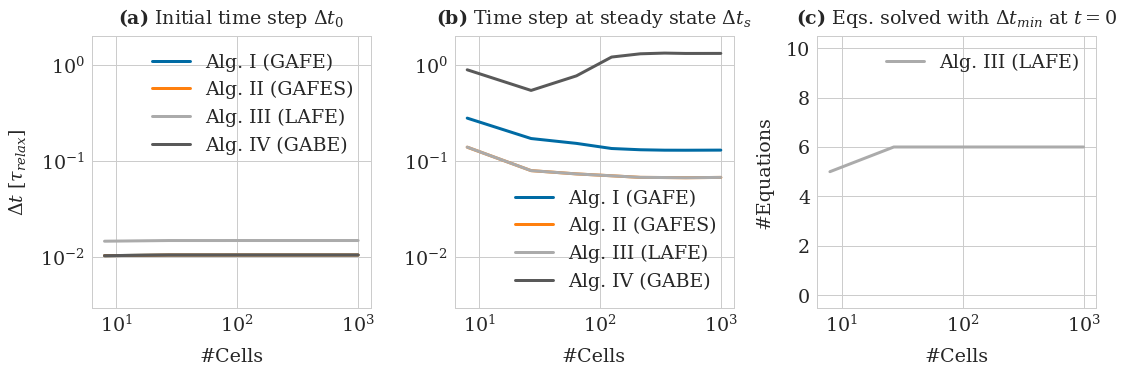

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharex=True, gridspec_kw={'hspace':0.2, 'wspace': 0.3})

ax1.get_shared_y_axes().join(ax1, ax2)

for alg in algorithms:
    ax1.loglog([l**3 for l in sizes], dt_0s[alg], label=labels[alg])
ax1.legend()
ax1.set_title(r'$\bf{(a)}$ Initial time step $\Delta t_0$')
ax1.set(xlabel='#Cells')
ax1.set(ylabel=r'$\Delta t \ [\tau_{relax}]$')
ax1.set_ylim([0.003, 2])

for alg in algorithms:
    ax2.loglog([l**3 for l in sizes], dt_sts[alg], label=labels[alg])
#ax2.legend()
ax2.set_title(r'$\bf{(b)}$ Time step at steady state $\Delta t_s$')
ax2.set(xlabel='#Cells')
ax2.legend(loc=4)
ax2.set_ylim([0.003, 2])



ax3.plot([l**3 for l in sizes], n_eqs, color=defcolors[2], label='Alg. III (LAFE)')
ax3.set_ylim([-0.5,10.5])
ax3.set(xlabel='#Cells')
ax3.set(ylabel='#Equations')
ax3.set_title(r'$\bf{(c)}$ Eqs. solved with $\Delta t_{min}$ at $t=0$')
ax3.legend()

plt.savefig('dependence_n_cells.pdf', bbox_inches='tight')


### Number of equations per level dependence on size of spheroid

In [50]:
sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10]

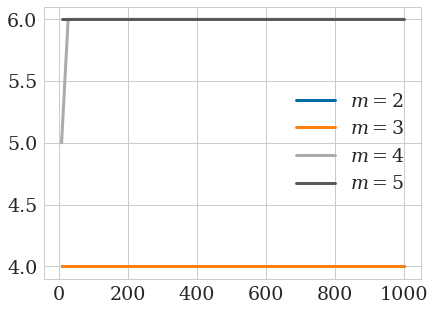

In [53]:
alg = 'EF_local_adap'
params[alg]['write_to_file'] = True
params[alg]['eps'] = 0.01
  
tf = 1.0
t_data = [0, tf]
seed=67

for m in [2, 3, 4, 5]:
    params[alg]['m0'] = m
    
    n_eqs = []
    for l in sizes:
        sheet = ut.setup_locally_compressed_spheroid(l,l,l, seed=seed)    

        try:
            os.remove('n_eq_per_level.txt')
        except FileNotFoundError:
            print('Nothing to delete.')

        ts, history = models[alg].simulate(sheet, t_data, params_cubic, params[alg], seed=seed)

        n_eq_per_level = np.loadtxt('n_eq_per_level.txt')

        n_eqs.append(n_eq_per_level[0,0])

    plt.plot([l**3 for l in sizes], n_eqs, label='$m=$'+str(m))
#        plt.plot(ts[:-1], n_eq_per_level[1,:], label='N='+str(l**3))
plt.legend()         

## Comparison of computational cost

We run the benchmark on rackham and plot the results here. I might actually be able to run this in a script locally. Might want to save data after every algorithm.

In [83]:
with open('data_from_cluster/exp_locally_compressed_spheroid_benchmark_s0.json', 'r') as f:
    data = json.load(f) 

In [84]:
dt_f = data['ts_s']['fixed_dt'][1] - data['ts_s']['fixed_dt'][0]

In [ ]:
algorithms.append('fixed_dt')
labels['fixed_dt'] = r'$\Delta t\approx$'+str(np.round(dt_f, 4))

algorithms.append()

In [ ]:
ts_s = data['ts_s']
exec_times = data['exec_times']

In [ ]:
F_evaluations = data['F_evals']
A_evaluations = data['A_evals']

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace':0.2, 'wspace': 0.35})

for alg in algorithms:
    ax1.plot(ts_s[alg][:-1], exec_times[alg], label=labels[alg])
    ax2.semilogy(ts_s[alg][:-1], F_evaluations[alg], label=labels[alg])
    ax3.semilogy(ts_s[alg][:-1], A_evaluations[alg][:len(ts_s[alg])-1], label=labels[alg])
ax2.legend()
ax1.set(xlabel=r'In-simulation time $t$ [$ \tau_{relax}$]')
ax1.set(ylabel='Wall time [s]')

ax2.set(xlabel=r'In-simulation time $t$ [$ \tau_{relax}$]')
ax3.set(xlabel=r'In-simulation time $t$ [$ \tau_{relax}$]')


ax2.get_shared_y_axes().join(ax2, ax3)
#ax3.set_yticklabels([])
ax2.set(ylabel=r'#F evaluations')
ax3.set(ylabel=r'#A evaluations')
plt.savefig('locally_comp_spheroid_benchmark.pdf', bbox_inches='tight')

## Compare error relative to fixed dt solution

Hmm, since I'm not running this on rackham the random seed will not have the same affect and hence the results will not be completely consistent. Is this a problem? Depends on how I phrase it. Worse case I run it on Rackham. 

How much does the seed affect?

In [80]:
seed = 67
cbmodel = cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim)
#sheet = ut.setup_locally_compressed_spheroid(10, 10, 10, seed=seed)
sheet = ut.setup_locally_compressed_spheroid(6, 6, 6, seed=seed)
tf = 4.0
t_data = [0.0, tf]


In [85]:
ref_ts, ref_sol = cbmodel.simulate(sheet, t_data, params_cubic, {"dt": dt_f}, seed=seed)
ref_traj = np.array(
            [
                [cell.position for cell in cell_list]
                for cell_list in ref_sol
            ]
        ) # (N_ref, n_cells, dim)

In [86]:
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap' ]
eps = 0.01
for alg in algorithms:
    params[alg]['eps'] = eps

In [87]:
error = {}
for alg in algorithms:
    ts, history = models[alg].simulate(sheet, t_data, params_cubic, params[alg], seed=seed)
    
    traj = np.array([[cell.position for cell in cell_list] for cell_list in history]) # (N, n_cells, dim)    
    
    interp = sci.interp1d(ts, traj, axis=0, bounds_error=False, kind='cubic', fill_value=tuple(traj[[0, -1], :, :]))(ref_ts[:])
    
    error[alg] = np.linalg.norm(interp - ref_traj, ord=np.inf, axis=1)
        

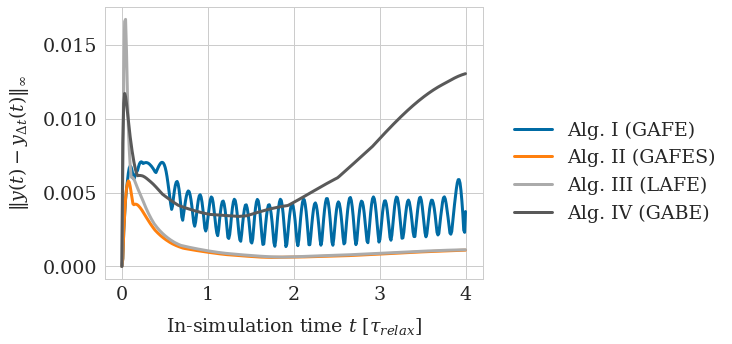

In [94]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
for alg in algorithms:
    ax.plot(ref_ts, np.mean(error[alg], axis=1), label=labels[alg]) # average over dimensions

fig.legend(loc=7)
fig.subplots_adjust(right=0.65)  

ax.set(xlabel=r'In-simulation time $t$ [$ \tau_{relax}$]')
ax.set(ylabel=r'$\Vert y(t) - y_{\Delta t}(t)\Vert_{\infty}$')
plt.savefig('locally_comp_spheroid_error.pdf', bbox_inches='tight')

Okay, so the locally adaptive one is sensitive to the direction of the initial cell division. I guess this is related to the problem with the two cell case and adding dimensions. (That problem disappears when updating F after each small time step as well.) And the error increases over time for seed=0. Less so for seed=1. It does something weird for seed=67. Is this due to me changing the definitions of Delta t_0 and Delta t_1? Maybe it's also that I handle each single level case individually now... Maybe I'm not doing it correctly when the time step is restricted by stability. Does the problem appear also for the larger spheroid of 216 cells?